In [1]:
import numpy as np
import torch
from diffusionmodel import *
from torch.optim import Adam
import bgflow.distribution.sampling.mcmc as MCMC
import bgflow.distribution.energy.double_well as DoubleWell
import bgflow.distribution.normal as Normal
import matplotlib.pyplot as plt


torch.random.manual_seed(199)

device = 'cuda'
T = 100


In [2]:
target = DoubleWell.DoubleWellEnergy(dim=1, b=-4., c=1.)
prior = Normal.NormalDistribution(dim=1)

net = torch.nn.Sequential(
    torch.nn.Linear(2, 64), 
    torch.nn.SiLU(), 
    torch.nn.Linear(64, 128),  
    torch.nn.SiLU(), 
    torch.nn.Linear(128, 64),  
    torch.nn.SiLU(), 
    torch.nn.Linear(64, 1))


ts = torch.linspace(0, T, 50)
xs = torch.linspace(-3, 3, 50)

X, Y = torch.meshgrid(xs, ts)

/srv/public/maaig92/miniconda3/envs/nequip/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


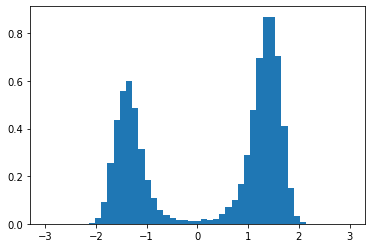

In [3]:
sampler = MCMC.GaussianMCMCSampler(energy=target, init_state=torch.tensor([0.]))

from utils import load_or_generate_and_then_save
datafilepath = 'double_well.npy'
data = torch.from_numpy(load_or_generate_and_then_save(datafilepath, lambda : sampler.sample(n_samples=50000)))

# plot histogram of the sampled data
counts, bins = np.histogram(data, bins=xs, density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True)
plt.show()

In [5]:
beta_schedule = torch.linspace(1e-4, 0.05, T)
diff_model = DiffusionModel(net=net, variance_schedule=beta_schedule, device=device)
print(sum([len(p) for p in diff_model.parameters()]))

514


/tmp/ipykernel_57659/1581441271.py:8: UserWarning: The following kwargs were not used by contour: 'keepdim'
  im1=plt.contourf(X.cpu(), Y.cpu(), z.cpu(), keepdim=True, levels=np.linspace(0, 0.5,50))


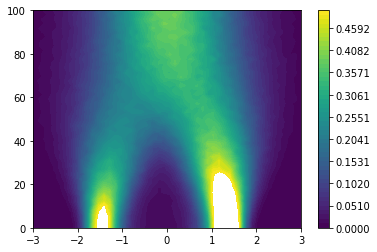

In [6]:
z = torch.zeros_like(X)
for i, t in enumerate(range(0, T, 2)):
    t_s=torch.full(data.shape, t).to(device)
    x_t = diff_model.apply_noise(x_0=data.to(device), t_s=t_s)[0]
    z[:, i] = torch.histogram(x_t.cpu(), bins=torch.cat([xs.cpu(), torch.tensor([6.])]), density=True)[0]


im1=plt.contourf(X.cpu(), Y.cpu(), z.cpu(), keepdim=True, levels=np.linspace(0, 0.5,50))
plt.colorbar(im1)

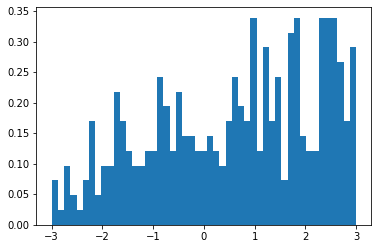

Epoch 0/50 total loss: 468.77395629882816065674283
Epoch 1/50 total loss: 399.2356872558594147461632
Epoch 2/50 total loss: 354.99578857421875092047456
Epoch 3/50 total loss: 225.9332733154297885162426
Epoch 4/50 total loss: 247.48237609863282438087506


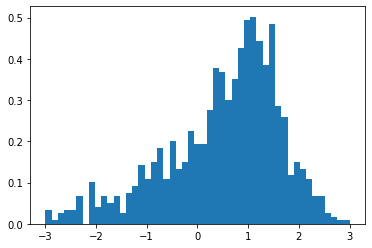

Epoch 5/50 total loss: 253.9988555908203608785639
Epoch 6/50 total loss: 202.97029113769532369995157
Epoch 7/50 total loss: 226.410293579101562414553
Epoch 8/50 total loss: 192.46253967285156374397256
Epoch 9/50 total loss: 219.34016418457032255902025


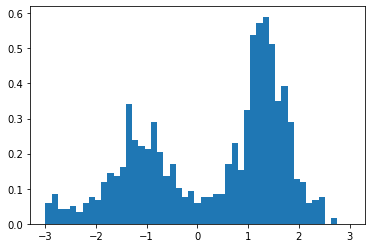

Epoch 10/50 total loss: 201.110717773437568328946
Epoch 11/50 total loss: 237.981735229492204577662
Epoch 12/50 total loss: 172.276718139648445034285
Epoch 13/50 total loss: 177.3679504394531209503-05
Epoch 14/50 total loss: 209.7629547119140642979354


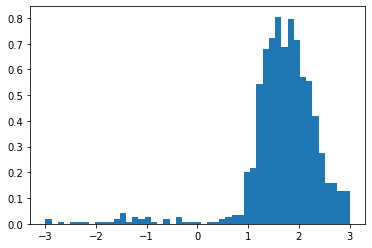

Epoch 15/50 total loss: 252.297485351562577801547
Epoch 16/50 total loss: 217.243041992187503442463
Epoch 17/50 total loss: 213.19287109375261881834
Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.
Epoch 18/50 total loss: 219.9069366455078
Epoch 19/50 total loss: 222.2536315917968818752457


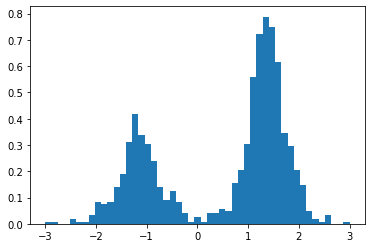

Epoch 20/50 total loss: 220.190917968755714654924
Epoch 21/50 total loss: 203.0926818847656237935566
Epoch 22/50 total loss: 170.792068481445395709612
Epoch 23/50 total loss: 152.945892333984382737224
Epoch 24/50 total loss: 171.432006835937561702347


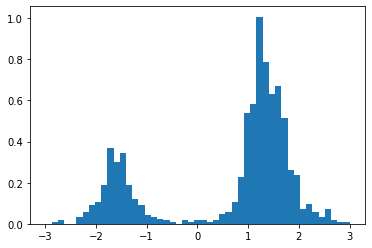

Epoch 25/50 total loss: 200.7885131835937552306073
Epoch 26/50 total loss: 173.421966552734382899805
Epoch 27/50 total loss: 192.205032348632859988405
Epoch 28/50 total loss: 167.05062866210938493333
Epoch 00030: reducing learning rate of group 0 to 2.5000e-04.
Epoch 29/50 total loss: 174.58131408691406


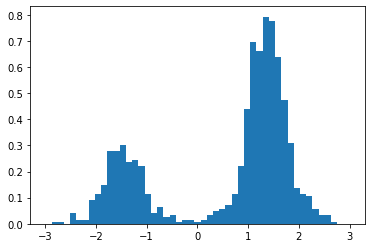

Epoch 30/50 total loss: 207.511184692382814625539
Epoch 31/50 total loss: 213.5878906256851444244267
Epoch 32/50 total loss: 160.591308593754132690336
Epoch 33/50 total loss: 204.612960815429751255235
Epoch 34/50 total loss: 222.857177734375554947852


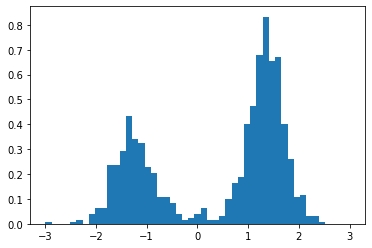

Epoch 35/50 total loss: 200.359497070312561370866
Epoch 36/50 total loss: 187.101364135742252426145
Epoch 37/50 total loss: 193.8300170898437539760495
Epoch 00039: reducing learning rate of group 0 to 1.2500e-04.
Epoch 38/50 total loss: 195.72409057617188
Epoch 39/50 total loss: 173.39517211914062962814


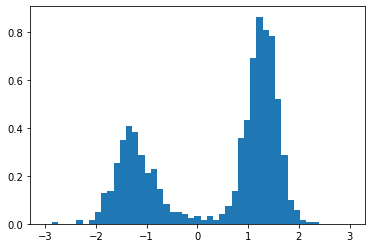

Epoch 40/50 total loss: 187.188446044921880501776
Epoch 41/50 total loss: 205.81430053710938994907
Epoch 42/50 total loss: 205.8574829101562555676851
Epoch 43/50 total loss: 146.182968139648443451444
Epoch 44/50 total loss: 156.003479003906256947603


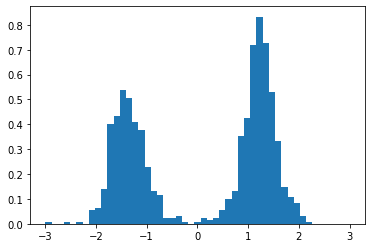

Epoch 45/50 total loss: 203.717071533203123092044
Epoch 46/50 total loss: 178.475051879882818141746
Epoch 47/50 total loss: 186.6432189941406203709422
Epoch 48/50 total loss: 175.388351440429771403969
Epoch 00050: reducing learning rate of group 0 to 6.2500e-05.
Epoch 49/50 total loss: 192.30230712890625


In [7]:
batch_size=128

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
optimizer = Adam(diff_model.parameters(), lr=1e-3)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, cooldown=3, verbose=True)

from train import train
def callback(model):
      samples = diff_model.sample([1000, 1])

      # plot histogram of the sampled data
      counts, bins = np.histogram(samples.cpu(), bins=xs, density=True)
      # plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
      plt.stairs(counts, bins, fill=True)
      plt.show()


train(diff_model, 
      loss_fn=torch.nn.MSELoss(), 
      optimizer=optimizer, 
      data_loader=train_loader, 
      scheduler=scheduler, 
      n_iterations=50, 
      device=device, 
      callback_interval=5,
      callback=callback)


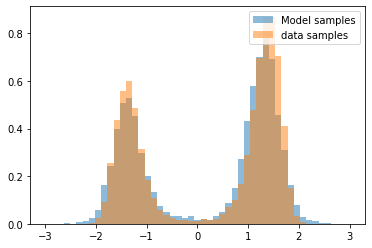

In [8]:
samples = diff_model.sample([10000, 1])

# plot histogram of the sampled data
counts, bins = np.histogram(samples.cpu(), bins=xs, density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True, alpha=0.5, label="Model samples")

# plot histogram of the sampled data
counts, bins = np.histogram(data, bins=xs, density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True, alpha=0.5, label="data samples")
plt.legend()